# Модуль 28. Мониторинги и управление качеством моделей

## Проект

**ПОСТАНОВКА ЗАДАЧИ**

В этом проекте вам необходимо реализовать мониторинг модели с помощью *Prometheus* и *Grafana*. Вы можете сами выбрать решаемую задачу и датасет.

**1. Введение**

Т.к. по условиям постановки задачи нам было позволено самостоятельно выбирать решаемую задачу и датасет для нее, то, с учетом критериев проверки данного проекта, было решено взять за основу проекта задачу и датасет из юнита 10 "Дообучение моделей. Практика" модуля 28. В этом юните на практике рассматривалось, как можно дообучать бустинги на примере модели LightGBM.

**Исходные данные:** Датасет *dataset_ml_28.csv*

In [1]:
# Импорт требуемых модулей и библиотек
import warnings
warnings.filterwarnings("ignore")

from prometheus_client import start_http_server, Gauge

import re
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

import joblib

Запустим локальный веб-сервер (порт 8000), чтобы обеспечить доступ к метрикам prometheus-клиента Python. Сами требуемые метрики и заполнение их значениями будет произведено далее.

In [2]:
if __name__ == '__main__':
    start_http_server(8000)

**2. Загрузка, анализ и предобработка данных датасета**

In [3]:
dataset = pd.read_csv('dataset_ml_28.csv')
dataset.head()

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Gender,Net Sales,Product Name,Claim
0,45341,28,C2B,Airlines,28.13,SINGAPORE,Online,34,F,112.5,Silver Plan,1
1,12958,37,JZI,Airlines,12.95,PHILIPPINES,Online,53,F,37.0,Basic Plan,0
2,18233,27,EPX,Travel Agency,0.00,UNITED STATES,Online,28,NaN,13.0,Cancellation Plan,0
3,31742,36,EPX,Travel Agency,0.00,SAUDI ARABIA,Online,1,NaN,34.0,Cancellation Plan,0
4,14381,26,CWT,Travel Agency,23.76,THAILAND,Online,33,NaN,39.6,Rental Vehicle Excess Insurance,0


Рассматриваемый датасет представляет собой данные о страхуемых в страховой компании и предназначен для предсказания, применения санкций к страхованию клиента или нет. Рассмотрим структуру и описание данных более детально.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    62288 non-null  int64  
 1   Age                   62288 non-null  int64  
 2   Agency                62288 non-null  object 
 3   Agency Type           62288 non-null  object 
 4   Commision (in value)  62288 non-null  float64
 5   Destination           62288 non-null  object 
 6   Distribution Channel  62288 non-null  object 
 7   Duration              62288 non-null  int64  
 8   Gender                22713 non-null  object 
 9   Net Sales             62288 non-null  float64
 10  Product Name          62288 non-null  object 
 11  Claim                 62288 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 5.7+ MB


In [5]:
dataset.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,39.666324,12.829703,60.958804,50.717064,0.200006
std,18065.417216,14.014652,23.498745,114.325330,63.166715,0.400008
min,0.000000,0.000000,0.000000,-2.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,1.880000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,14.440000,59.000000,58.000000,0.000000
max,63323.000000,118.000000,262.760000,4881.000000,682.000000,1.000000


При беглом экспресс-анализе полученных данных можно выделить следующие моменты:

* *Claim* - это целевой бинарный признак, который означает выставлять или нет претензию страховщику.
* В признаке *Gender* (пол) очень много пропусков. Заполнить эти пропуски на основании других данных невозможно. Поэтому удалим этот признак.
* Признак *Age* (возраст) сделаем категориальным. Для этого сгруппируем клиентов по возрасту: *Child* (ребенок), *Adult* (взрослый) и *Senior* (пожилой возраст).
* Признак *Duration* (продолжительность) имеет в минимуме отрицательное значение, что не применимо для фактора времени. Такие данные надо отбросить.
* Максимальное значение в признаке *Duration* (продолжительность) - 4881 дней также весьма сомнительно для туристических поездок. Установим максимальное значение *Duration* в 90 дней (~3 месяца).
* Преобразуем для использования в модели все категориальные значения в dummy-признаки.

In [6]:
# Создадим функцию конвертации возраста страхуемого в категориальный признак
def age_convert(age):
    result = ''
    if(age <= 21):
        result = 'Child'
    elif(age <= 60):
        result = 'Adult'
    else:
        result = 'Senior'
    return result

In [7]:
# Комплексная функция предобработки данных по строке датасета
def data_pre_processing(df):
    
    # Удалим колонку возраста
    df.drop('Gender',axis=1, inplace=True)
    
    # Преобразование возраста в категорию
    df['Age Group'] = df['Age'].map(lambda x: age_convert(x))
    
    # Обработка запредельных значений продолжительности поездки
    df.loc[df.Duration < 0, 'Duration'] = df['Duration'].median()
    df.loc[df.Duration > 90, 'Duration'] = 90
    
    df = pd.get_dummies(df, columns=['Agency', 'Agency Type', 'Destination', 'Distribution Channel', 'Product Name', 'Age Group'], drop_first=True)
    
    return df

In [8]:
dataset = data_pre_processing(dataset)
dataset.head()

,ID,Age,Commision (in value),Duration,Net Sales,Claim,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,...,Product Name_Silver Plan,Product Name_Single Trip Travel Protect Gold,Product Name_Single Trip Travel Protect Platinum,Product Name_Single Trip Travel Protect Silver,Product Name_Spouse or Parents Comprehensive Plan,Product Name_Ticket Protector,Product Name_Travel Cruise Protect,Product Name_Value Plan,Age Group_Child,Age Group_Senior
0,45341,28,28.13,34,112.5,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,12958,37,12.95,53,37.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18233,27,0.00,28,13.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31742,36,0.00,1,34.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14381,26,23.76,33,39.6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Т.к. основной целью данного проекта является демонстрация навыков дообучения и мониторинга моделей, то более глубокую процедуру EDA мы проводить не будем. Так же не будем производить поиск наилучших параметров используемой модели, а сосредоточимся на решении поставленных в текущем модуле задач. Сформируем данные для использования в модели.

In [9]:
X = dataset.drop('Claim', axis = 1)
y = dataset['Claim']

**3. Создание и обучение модели**

В качестве модели для использования в данном проекте используется *LightGBM*. Это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом. Одной из заявленных возможностей данного фреймворка является его поддержка параллельного и распределенного обучения. Именно эту особенность мы будем использовать для реализации функционала дообучения модели.

Изначально отделим в исходном датасете 20% данных в отдельную выборку, эмулирующую дополнительные данные, которые формально придут к нам позже, при уже обученной модели. Для этот воспользуемся классическим методом *train_test_split* из библиотеки *sklearn*.

In [10]:
X_main, X_add, y_main, y_add = train_test_split(X, y, test_size=0.2, random_state=42)

Для реализации и проверки возможности дообучения модели, попробуем воссоздать поток реальных данных с помощью т.н батчей. Для этого разобьем main-данные на части (батчи) и будем их затем по порядку считывать при обучении модели.

In [11]:
# Функция разбиения входного датасета на части (батчи)
def streaming_reading(X_train, y_train, batch_size=5000):
    X = []
    y = []
    current_line = 0
    
    train_data, train_label = shuffle(X_train, y_train, random_state=42)
    train_data = train_data.to_numpy()
    
    for row, target in zip(train_data, train_label):
        X.append(row)
        y.append(target)

        current_line += 1
        if current_line >= batch_size:
            X, y = np.array(X), np.array(y)
            yield X, y
            X, y = [], []
            current_line = 0

Реализуем функцию нарастающего LightGBM, которая работает с батчами данных, последовательно обучая модель. Данная функция будет в итоге возвращать обученную модель, у которой мы оценим метрики и которую мы сохраним в файл, для дальнейшего дообучения.

In [12]:
def IncrementalLightGBM(X, y):  
    gbm = None

    params = {
        'task': 'train',
        'application': 'binary',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['binary_logloss', 'auc'], 
        'max_bin': 255,
    }
    streaming_train_iterators = streaming_reading(X, y, batch_size=5000)

    for i, data in enumerate(streaming_train_iterators):
        X_batch = data[0]
        y_batch = data[1]
        X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.1, random_state=42)
        y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm, 
                        early_stopping_rounds=10,
                        verbose_eval=False,
                        keep_training_booster=True)  

        print("{} time".format(i))  
        score_train = dict([(score[1], score[2]) for score in gbm.eval_train()])
        
        print('The score of the current model in the training set is: logloss=%.4f, auc=%.4f, \n'
              % (score_train['binary_logloss'], score_train['auc']))

    return gbm

Запустим процесс обучения.

In [13]:
train_X, test_X, train_y, test_y = train_test_split(X_main, y_main, test_size = 0.2, random_state=42)
gbm = IncrementalLightGBM(train_X, train_y)

pred_y = gbm.predict(test_X)
pred_classes = np.where(pred_y > 0.5, 1, 0)

print(f'F1 score: {f1_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Precision: {precision_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Recall: {recall_score(test_y, pred_classes)}')

[LightGBM] [Info] Number of positive: 860, number of negative: 3640
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191111 -> initscore=-1.442807
[LightGBM] [Info] Start training from score -1.442807
0 time
The score of the current model in the training set is: logloss=0.1508, auc=0.9916, 

[LightGBM] [Info] Number of positive: 887, number of negative: 3613
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Numb

In [14]:
# Сохраним обученную модель в файл
joblib.dump(gbm, 'loan_model.pkl')

['loan_model.pkl']

In [15]:
# Определим набор метрик для передачи в Prometheus
g_f1_score = Gauge('my_f1_score', 'F1 score')
g_precision_score = Gauge('my_precision_score', 'Precision score')
g_recall_score = Gauge('my_recall_score', 'Recall score')

In [16]:
# Зафиксируем полученные значения метрик модели в метрики для передачи в Prometheus
g_f1_score.set(f1_score(test_y, pred_classes))
g_precision_score.set(precision_score(test_y, pred_classes))
g_recall_score.set(recall_score(test_y, pred_classes))

В итоге мы получили модель, обученную на исходных *main*-данных, значения ее метрик и отправили эти метрики в систему мониторинга данных *Prometheus*.

**4. Дообучение модели**

Для демонстрации возможности перспективного дообучения полученной модели и возможности мониторинга ее метрик, воспользуемся отложенной ранее *add*-выборкой. Создадим функцию для дообучения новыми данными. Это модифицированная функция *IncrementalLightGBM()* из прошлого пункта, настроенная для работы только с одним батчем и использованием имеющейся входной модели.

In [17]:
def AddDataLightGBM(X, y, gbm):  
    params = {
        'task': 'train',
        'application': 'binary',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['binary_logloss', 'auc'], 
        'max_bin': 255,
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    y_train = y_train.ravel()
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    init_model=gbm, 
                    early_stopping_rounds=10,
                    verbose_eval=False,
                    keep_training_booster=True)  

    score_train = dict([(score[1], score[2]) for score in gbm.eval_train()])
        
    print('The score of the current model in the training set is: logloss=%.4f, auc=%.4f, \n'
              % (score_train['binary_logloss'], score_train['auc']))

    return gbm

In [18]:
# Восстановим исходную модель из файла
gbm = joblib.load('loan_model.pkl')

In [19]:
# Проведем преобразование имен колонок, для исключения ошибки -
# LightGBMError: Do not support special JSON characters in feature name.
X_add = X_add.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Дообучение новыми данными
gbm_new = AddDataLightGBM(X_add, y_add, gbm)

# Оценка метрик новой модели
y_pred = gbm.predict(X_add)
pred_classes = np.where(y_pred > 0.5, 1, 0)

print(f'F1 score: {f1_score(y_add, pred_classes)}')
print('------------------------------------------')
print(f'Precision: {precision_score(y_add, pred_classes)}')
print('------------------------------------------')
print(f'Recall: {recall_score(y_add, pred_classes)}')

[LightGBM] [Info] Number of positive: 2248, number of negative: 8964
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 75
The score of the current model in the training set is: logloss=0.1055, auc=0.9957, 

F1 score: 0.8589079314467915
------------------------------------------
Precision: 0.8484251968503937
------------------------------------------
Recall: 0.8696529459241323


In [20]:
# Сохраним обновленную модель в файл
joblib.dump(gbm_new, 'loan_model.pkl')

['loan_model.pkl']

In [21]:
# Зафиксируем полученные значения метрик модели в метрики для передачи в Prometheus
g_f1_score.set(f1_score(y_add, pred_classes))
g_precision_score.set(precision_score(y_add, pred_classes))
g_recall_score.set(recall_score(y_add, pred_classes))

Видно, что значения метрик модели изменились после дообучения модели новыми данными.

**5. Описание настройки передачи метрик из Pyhton**

В программном коде *Python* для передачи контролируемых метрик модели в программу cкраппинга метрик *Prometheus* используется компонент *Prometheus Python Client* (https://github.com/prometheus/client_python). Запуск веб-сервера, формирующего исходящие метрики этого компонента производится в конце п.1 данного проекта.

Запуск всей системы монторинга, включая все описанные далее компоненты, производился на операционной системе Windows 10, на одном локальном ПК. В связи с этим все рассмотренные далее примеры основаны на данном утверждении.

Данные метрик, которые отдает веб-сервер *Prometheus Python Client* выводятся в порт 8000 и могут быть рассмотрены через браузер по адресу http://localhost:8000/metrics. После выполнения приведенных выше разделов проекта они будут иметь следующий вид:

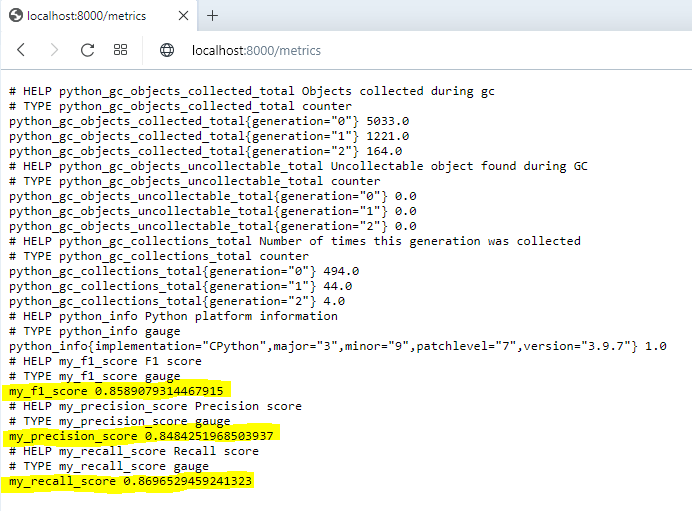

В скриншоте выделены пользовательские метрики, которые мы определили и зафиксировали по ходу обучения и дообучения модели в пунктах 3 и 4 проекта. Точнее, на скриншоте показаны последние значения после дообучения модели дополнительными данными. Эти, а так же другие стандартные метрики *Prometheus Python Client*, являются входными данными для следующего компонента системы мониторинга - программы *Prometheus*.

**6. Описание настроек скаппинга метрик в Prometheus**

Загрузка *Prometheus* для нужной версии ОС доступна по адресу https://prometheus.io/download/.

Перед запуском *Prometheus*, необходимо произвести настройку конфигурационного файла этой программы *prometheus.yml*, для учета нового задания, которое должен обрабатывать *Prometheus*. Добавим в конце этого файла следующие строки:

 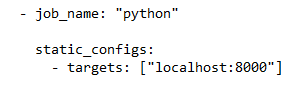

Здесь: 
* *job_name* - имя добавляемого в *Prometheus* задания;
* *targets* - URL-путь к источнику метрик для скраппинга (в нашем случае веб-сервер *Prometheus Python Client*, см. п.5).

После запуска программы *Prometeus* со ссылкой на модифицированный конфигурационный файл (команда: *prometheus --config.file=prometheus.yml* из папки с развернутым *Prometeus*), станет доступна работа с веб-интерфейсом *Prometeus*. По умолчанию этот интерфейс имеет адресу http://localhost:9090/. Ппроверим через меню *"Staus"* этого интерфейса подключение нашего задания к *Prometeus*:

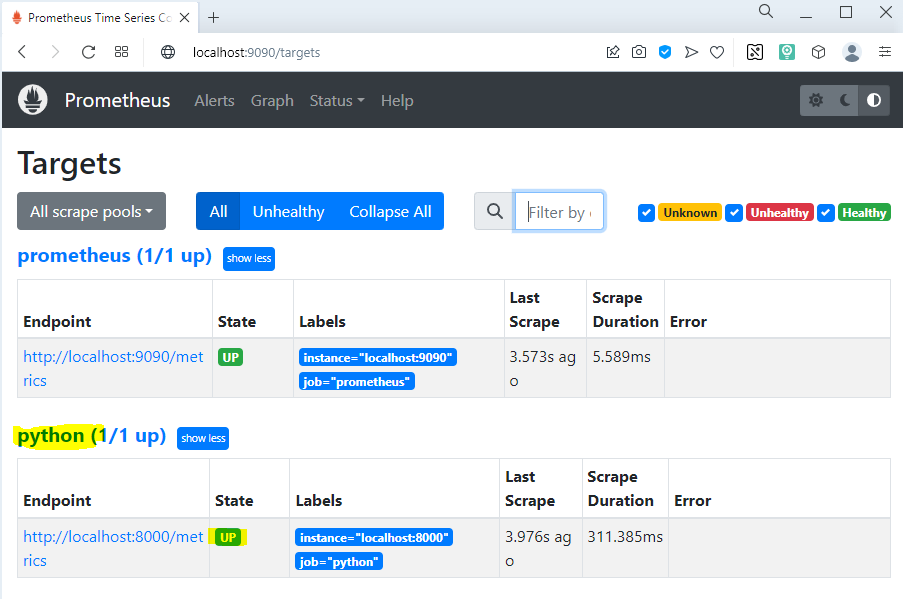

Из приведенного скриншота видно, что нужное нам задание *"python"* подключилось к *Prometeus* и находится в рабочем состоянии, периодически собирая данные из нашего источника метрик (*Prometheus Python Client*).

Теперь нам необходимо выделить в *Prometeus* интересующие нас метрики. Заполним панели в *Prometeus* следующим образом.

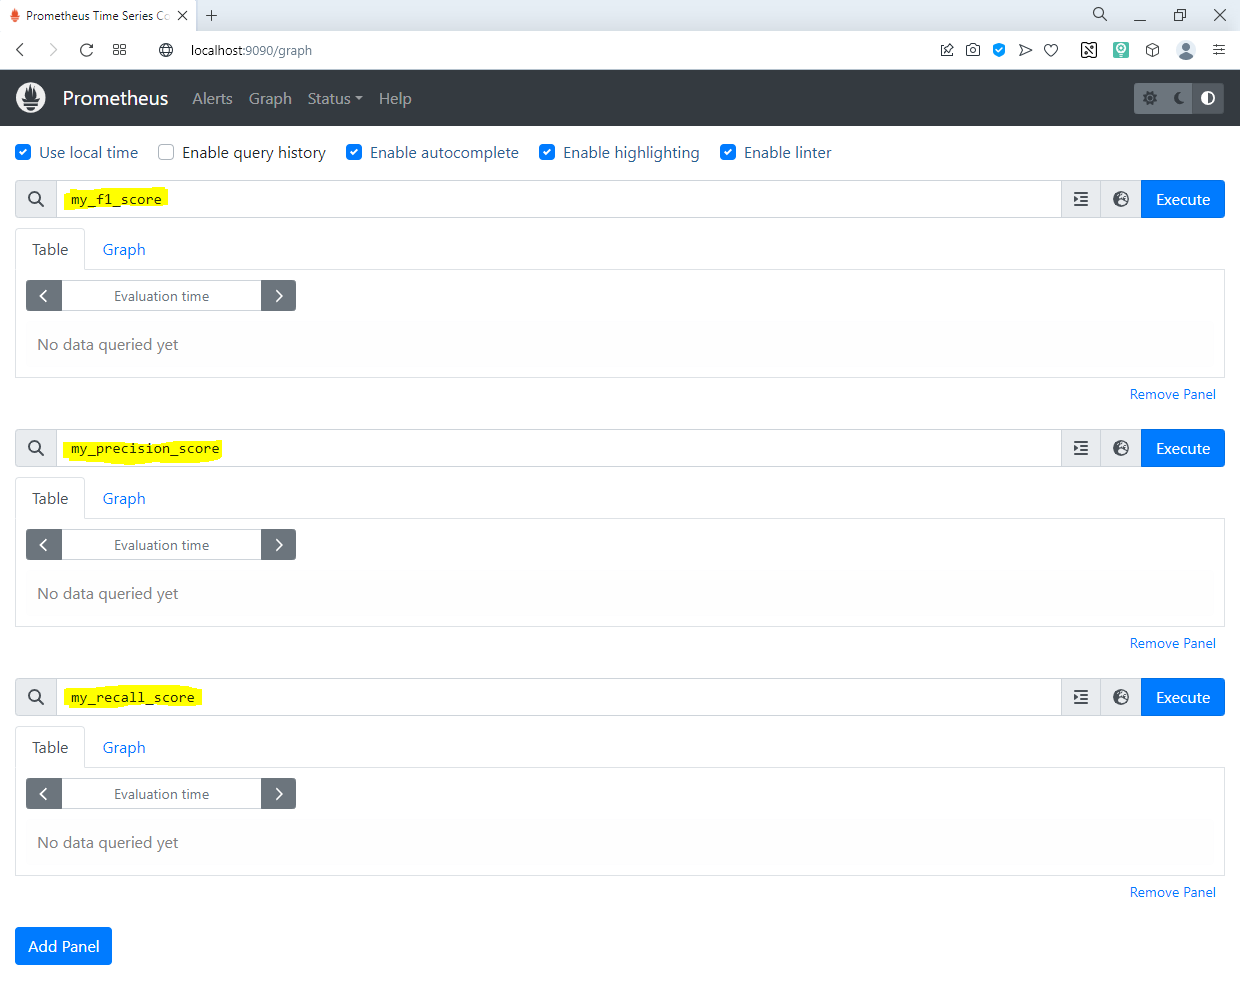

Наличие указанных настроек в *Prometeus* позволяет отразить на каждой панели график (*Graph*) нужной нам метрики, но по условиям задания к проекту, визуализация метрик должна быть произведена через программу *Grafana*, которая позволяет получить лучшее графическое представление временных рядов по нашим метрикам и имеет более продвинутые инструменты работы с графиками.

**7. Описание настроек Grafana**

*Grafana* — программная система визуализации данных, ориентированная на данные систем IT-мониторинга. В нашей системе мониторинга *Grafana* является завершающим элементом, который позволит нам увидеть изменения метрик модели со временем. Это может происходить при дообучении модели.

Описание и другая информация по системе *Grafana*: https://grafana.com/,
https://github.com/grafana/grafana?ysclid=lg94cdruvz420026724

*Grafana*, как и рассмотренный ранее *Prometeus*, имеет возможность работы в различных операционных системах. После установки на ПК, доступ к ее веб-интерфейсу осуществляется по адресу: http://localhost:3000/. 

Для сопряжения ее работы с описанной ранее программой *Prometeus*, нам необходимо определить в *Grafana* так называемый источник данных, т.е. определить путь к метрикам *Prometeus*. Это можно настроить через меню в веб-интерфейсе: *"Конфигурация"* (*Configuration*), закладке *"Источники данных"* (*Data sources*), или через прямую ссылку http://localhost:3000/datasources.

Создадим, на основе доступного в *Grafana* шаблона для *Grafana*, следующий источник данных:

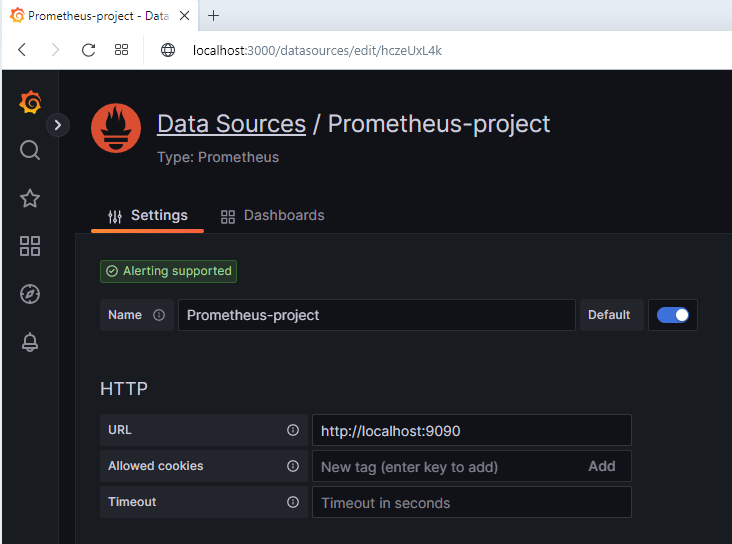

Важным параметром настройки источника данных в *Grafana* является путь URL к веб-серверу *Prometeus*, на котором производится реальный сбор данных метрик для отражения на графиках *Grafana*. При сохранении настройки источника данных, система проверит соединение и сообщит о результате этой операции. При успешном соединении получим следующее сообщение:

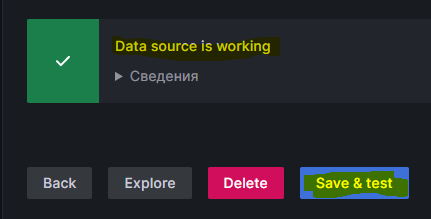

Далее создадим и сохраним новый дашборд в *Grafana* с нужными нам для мониторинга метриками. В нашем случае это дашборд *"Project M28"*.

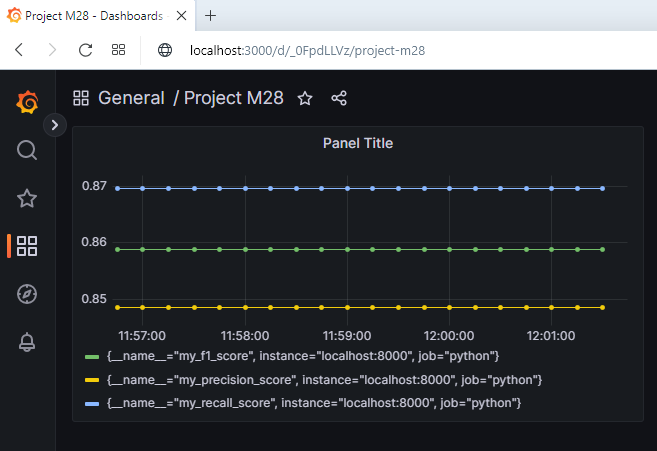

Из скриншота видно, что с периодом отражения данных в 5 минут и не изменяемыми данными в исходной модели, *Grafana* отражает статичные значения последних метрик после дообучения модели.

**8. Анализ данных в Grafana при работе модели**

Если рассматривать в *Grafana* данные по работе модели данного проекта в динамике, с момента ее запуска и последующего дообновления, то можно увидеть следующие результаты. Время в данном случае условно, т.к. у нас присутствует интерактивное управление выполнением программного кода в ноутбуке.

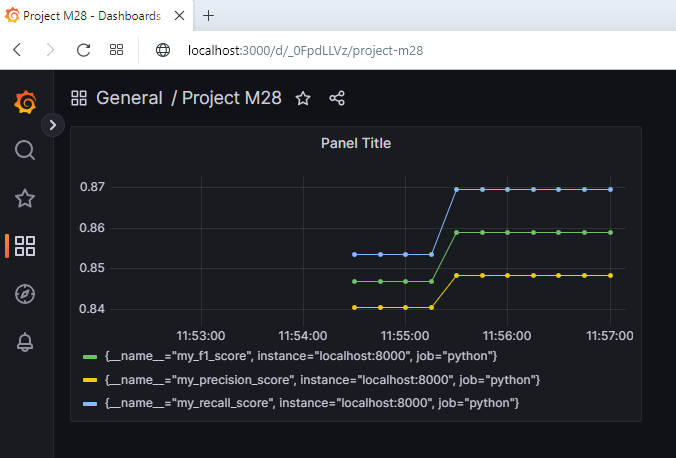

Здесь можно выделить следующие моменты:

1. До момента времени 11:54:30 ноутбук с проектом не был запущен в *Jupyter notebook*. В этот момент времени данных по нашим метрикам модели не было (нет графиков).
2. В 11:54:30 был запущен ноутбук и произведено обучение модели на *main*-данных. Мы получили первичные метрики обученной модели.
3. До момента времtни 11:55:15 данные метрик модели не менялись, что соответствует условному Этапу 1 времени жизни модели в продакшене - она использовалась в сервисе на первично обученных данных.
4. В промежуток времени с 11:55:15 до 11:55:30 произошло дообучение модели на add-данных, что привело к улучшению метрик обновленной модели. Это условно соответствует Этапу 2 времени жизни молели - обновление модели с учетом новых поступивших данных.
5. Далее значения метрик модели не меняются, до дооубения модели в будущем.

**Выводы**

1. В ходе работы над проектом был выбран датасет и задача, по которой была создана модель с возможностью дообучения дополнительными данными. Эти данные могут появляться и использоваться уже при эксплуатации данной модели в продакшене для обновления модели. Данная ситуация эмулируется в проекте с помощью разделения исходного датасета на части.
2. Произведена доработка программного кода реализации модели для возможности выгрузки значений контролируемых метрик модели во внешние системы мониторинга.
3. Реализована система мониторинга метрик модели с помощью внешнего программного обеспечения *Prometeus* и *Grafana* для визуализации временного ряда изменения метрик созданной модели.
4. Проведен анализ изменения метрик модели при ее динамическом дообучении на основании визуальных данных метрик в *Grafana*. В нашем случае после дообучения модели произошло улучшение всех метрик модели.
5. Получен опыт по организации замкнутых систем, использующих в своей работе различное программное обеспечение.